# Imports

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import optimize, stats

# Equal Variance
This notebook runs two SDT simulations:
1) Equal-variance generation (signal sd = 1) analyzed with the equal-variance d' formula.
2) Unequal-variance generation (signal sd = 0.8) but still analyzed with the equal-variance d' formula to show the bias.

### General Variables

In [152]:
N_EXPERIMENTS = 100
N_SIGNAL_TRIALS = 50
N_NOISE_TRIALS = 50
SIGNAL_MEAN = 1.0

General settings:
- `N_EXPERIMENTS`, `N_SIGNAL_TRIALS`, `N_NOISE_TRIALS` set how many experiments and trials per condition are simulated.
- `SIGNAL_MEAN` (d' ground truth) and the criteria for each observer define sensitivity and bias.
- The RNG seed makes runs reproducible so results and plots match the text.

In [153]:
rng = np.random.default_rng(123)

In [154]:
observers = {
        "yes_biased": 0.4,   # favors yes responses
        "no_biased": 1.6,     # favors no responses
        "mild_bias": 1,     # near-neutral criterion
    }

### Experiment Functions

In [155]:
def simulate_observer(
    rng,
    criterion,
    n_experiments=N_EXPERIMENTS,
    n_signal=N_SIGNAL_TRIALS,
    n_noise=N_NOISE_TRIALS,
    d_prime=SIGNAL_MEAN,
    signal_sd=1.0,
):
    counts = []
    for _ in range(n_experiments):
        signal = rng.normal(loc=d_prime, scale=signal_sd, size=n_signal)
        noise = rng.normal(loc=0.0, scale=1.0, size=n_noise)

        hits = int(np.sum(signal > criterion))
        misses = n_signal - hits
        false_alarms = int(np.sum(noise > criterion))
        correct_rejections = n_noise - false_alarms

        counts.append((hits, misses, false_alarms, correct_rejections))
    return counts



In [156]:
def summarize_counts(counts):
    arr = np.array(counts, dtype=float)
    hit_rates = arr[:, 0] / (arr[:, 0] + arr[:, 1])
    false_alarm_rates = arr[:, 2] / (arr[:, 2] + arr[:, 3])
    yes_rates = (arr[:, 0] + arr[:, 2]) / (arr[:, 0] + arr[:, 1] + arr[:, 2] + arr[:, 3])

    return {
        "mean_hit_rate": hit_rates.mean(),
        "mean_false_alarm_rate": false_alarm_rates.mean(),
        "mean_yes_rate": yes_rates.mean(),
    }

In [157]:
def loglinear_rates(hits, misses, false_alarms, correct_rejections):
    """Apply log-linear correction to avoid 0/1 rates before z-transform."""
    hit_rate = (hits + 0.5) / (hits + misses + 1)
    false_alarm_rate = (false_alarms + 0.5) / (false_alarms + correct_rejections + 1)
    return hit_rate, false_alarm_rate

In [158]:
def d_prime_from_counts(hits, misses, false_alarms, correct_rejections):
    hit_rate, false_alarm_rate = loglinear_rates(hits, misses, false_alarms, correct_rejections)
    return norm.ppf(hit_rate) - norm.ppf(false_alarm_rate)

In [159]:
def compute_d_primes(counts):
    return np.array([d_prime_from_counts(*c) for c in counts])

In [160]:
def plot_histograms(dprime_by_observer):
    n_obs = len(dprime_by_observer)
    fig, axes = plt.subplots(1, n_obs, figsize=(4 * n_obs, 3.5), sharey=True)
    if n_obs == 1:
        axes = [axes]

    for ax, (name, values) in zip(axes, dprime_by_observer.items()):
        ax.hist(values, bins=15, color="#4682b4", edgecolor="black", alpha=0.8)
        ax.axvline(SIGNAL_MEAN, color="tomato", linestyle="--", linewidth=1.5, label="true d'")
        ax.set_title(f"{name}")
        ax.set_xlabel("d' estimate")
        ax.set_ylabel("count")
        ax.legend()

    fig.tight_layout()
    plt.show()
    return fig

What the helper functions do:
- `simulate_observer` draws noise trials from N(0,1) and signal trials from N(mu=SIGNAL_MEAN, sd=signal_sd), then applies the criterion to count hits/false alarms.
- `loglinear_rates` adds 0.5 to every cell to avoid 0 or 1 rates before the z-transform, preventing infinite z-scores for small samples.
- `d_prime_from_counts` computes d' = z(hit rate) - z(false alarm rate) using the equal-variance assumption.
- `compute_d_primes` runs that per experiment so we get a distribution of d' estimates.
- `plot_histograms` shows the sampling distribution of d' per observer and marks the true generating mean (SIGNAL_MEAN).

### Experiment with variance 1

=== Equal-variance generation (signal sd = 1.0) ===
yes_biased (c=+0.4)
  mean hit rate: 0.731
  mean false alarm rate: 0.340
  mean yes rate: 0.536
  first experiment counts (hits, misses, false alarms, correct rejections): (38, 12, 14, 36)
  d' mean (100 experiments): 1.021 +/- 0.260



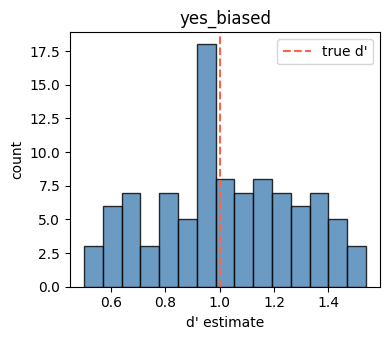

no_biased (c=+1.6)
  mean hit rate: 0.276
  mean false alarm rate: 0.056
  mean yes rate: 0.166
  first experiment counts (hits, misses, false alarms, correct rejections): (17, 33, 2, 48)
  d' mean (100 experiments): 0.969 +/- 0.352



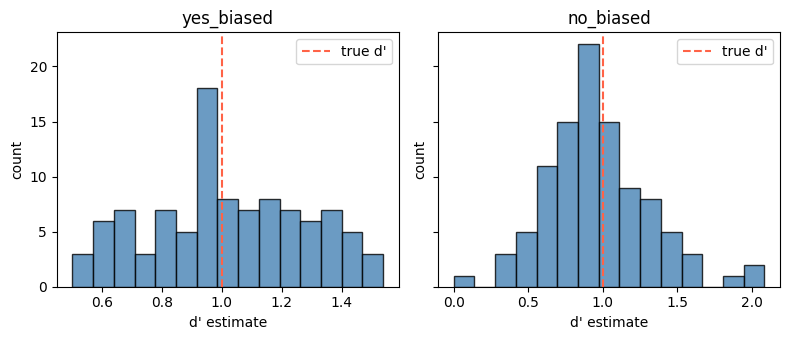

mild_bias (c=+1.0)
  mean hit rate: 0.506
  mean false alarm rate: 0.169
  mean yes rate: 0.337
  first experiment counts (hits, misses, false alarms, correct rejections): (23, 27, 4, 46)
  d' mean (100 experiments): 0.972 +/- 0.269



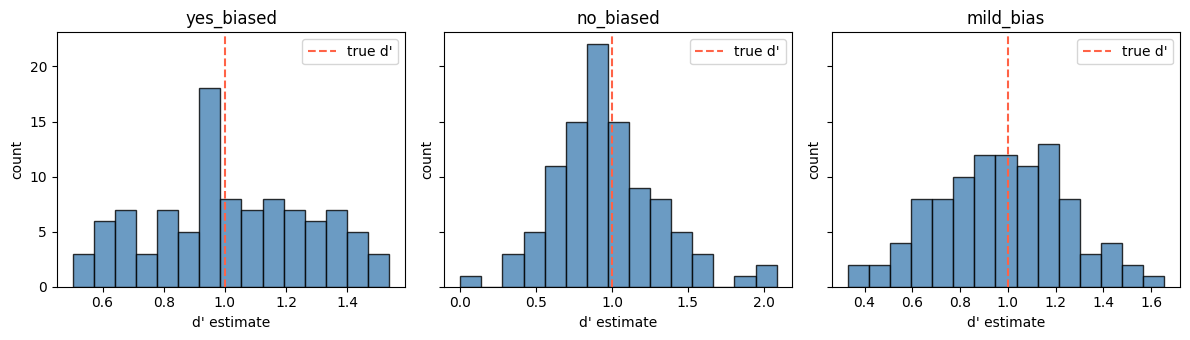

In [161]:
dprime_results = {}
signal_sd=1.0
label="Equal-variance generation"


print(f"=== {label} (signal sd = {signal_sd}) ===")
dprime_results = {}

for name, criterion in observers.items():
    counts = simulate_observer(rng, criterion, signal_sd=signal_sd)
    summary = summarize_counts(counts)
    d_primes = compute_d_primes(counts)
    dprime_results[name] = d_primes

    print(f"{name} (c={criterion:+.1f})")
    print(f"  mean hit rate: {summary['mean_hit_rate']:.3f}")
    print(f"  mean false alarm rate: {summary['mean_false_alarm_rate']:.3f}")
    print(f"  mean yes rate: {summary['mean_yes_rate']:.3f}")
    print("  first experiment counts (hits, misses, false alarms, correct rejections): "f"{counts[0]}")
    print(f"  d' mean (100 experiments): {d_primes.mean():.3f} +/- {d_primes.std(ddof=1):.3f}")
    print()

    plot_histograms(dprime_results)

#### QUESTION - Are the distributions centered around the true underlying value of d-prime for each of the simulated data sets?

Interpretation (equal-variance generation):
- Even though observers have different criteria, d' estimates cluster around the true value (?1) because the generating model matches the equal-variance assumption used in estimation.
- Bias mainly shifts yes/no rates; sensitivity estimates stay consistent across observers when the model is correctly specified.

Under the equal-variance SDT model, d′ is determined by how separated the signal and noise distributions are, the μ_signal − μ_noise in standardized units. 
The observer’s criterion only sets where they place the decision boundary; it changes the split between hits/misses and false alarms/correct rejections but does not move the underlying distributions. So when the model is correctly specified (equal variances, correct mean separation), all observers are sampling from the same signal/noise distributions; after log-linear correction, z(hit rate) − z(false alarm rate) recovers the same separation regardless of where the criterion sits. 
That’s why d′ estimates cluster around the same value even though their bias (c) differs.

Regarding the log-linear correction, we do it to prevent 0 or 1 hit/fal-alarm rates from blowing up the z-scores. With finite trials, an observer can easily get perfect hits or zero false alarms. This means, z(1) tends to +∞ and z(0) tends to -∞ which makes d-prime undefined. By adding 0.5 to each cell and 1 to each marginal, we pull extreme porportions slightly inward so z(hit rate) and z(false alarm rate) stay finite and dprime remains usable, specially with small sample sizes 

Helper functions (unequal-variance rating SDT):
- `simulate_confidence_responses` draws latent evidence and bins into 4 ratings via the criteria.
- `rating_counts` tallies counts per rating for signal and noise.
- `cumulative_rates` builds ROC points from most liberal to most conservative with log-linear correction to avoid 0/1 extremes.
- `fit_unequal_variance_params` fits the zROC line: slope = s? (sd ratio), intercept = d_a? (sensitivity under unequal-variance SDT).
- `roc_auc` computes trapezoidal AUC including (0,0) and (1,1).
- `run_experiments` loops 100 times to collect d_a?, s?, AUC.
- `plot_distributions` shows histograms with vertical lines at true values.

#### Experiment with variance 0.8

=== Equal-variance generation (signal sd = 0.8) ===
yes_biased (c=+0.4)
  mean hit rate: 0.783
  mean false alarm rate: 0.340
  mean yes rate: 0.561
  first experiment counts (hits, misses, false alarms, correct rejections): (39, 11, 12, 38)
  d' mean (100 experiments): 1.187 +/- 0.260



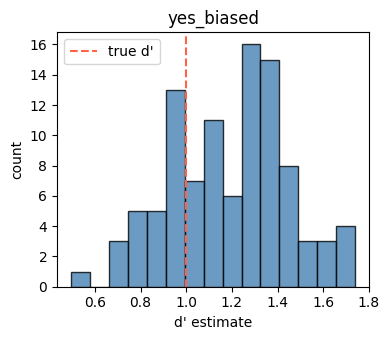

no_biased (c=+1.6)
  mean hit rate: 0.224
  mean false alarm rate: 0.054
  mean yes rate: 0.139
  first experiment counts (hits, misses, false alarms, correct rejections): (11, 39, 1, 49)
  d' mean (100 experiments): 0.833 +/- 0.310



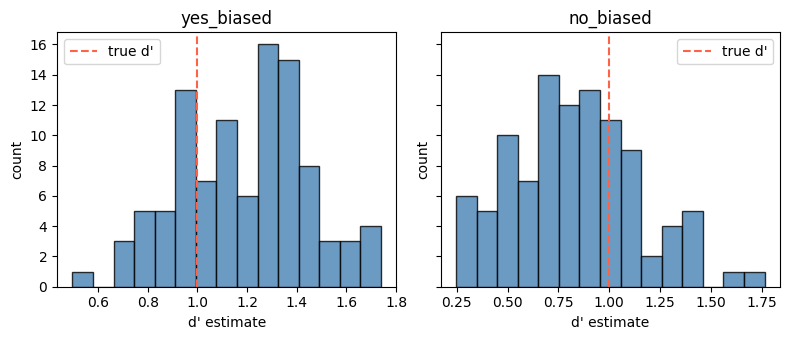

mild_bias (c=+1.0)
  mean hit rate: 0.499
  mean false alarm rate: 0.158
  mean yes rate: 0.328
  first experiment counts (hits, misses, false alarms, correct rejections): (27, 23, 8, 42)
  d' mean (100 experiments): 1.000 +/- 0.296



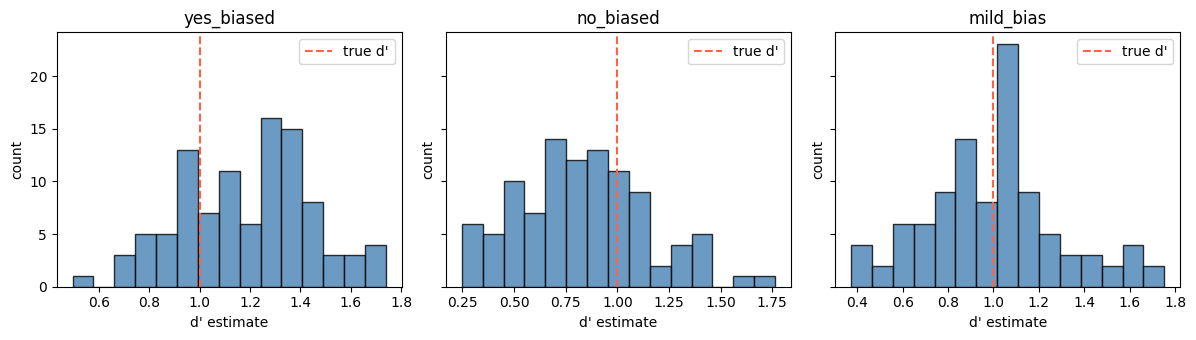

In [162]:
dprime_results = {}
signal_sd=0.8
label="Equal-variance generation"


print(f"=== {label} (signal sd = {signal_sd}) ===")
dprime_results = {}

for name, criterion in observers.items():
    counts = simulate_observer(rng, criterion, signal_sd=signal_sd)
    summary = summarize_counts(counts)
    d_primes = compute_d_primes(counts)
    dprime_results[name] = d_primes

    print(f"{name} (c={criterion:+.1f})")
    print(f"  mean hit rate: {summary['mean_hit_rate']:.3f}")
    print(f"  mean false alarm rate: {summary['mean_false_alarm_rate']:.3f}")
    print(f"  mean yes rate: {summary['mean_yes_rate']:.3f}")
    print("  first experiment counts (hits, misses, false alarms, correct rejections): "f"{counts[0]}")
    print(f"  d' mean (100 experiments): {d_primes.mean():.3f} +/- {d_primes.std(ddof=1):.3f}")
    print()

    plot_histograms(dprime_results)

Interpreting the magnitude estimation results:
- For a=0.33 (compressive), log growth resembles the shallow power law, so the Fechner fit should look reasonable; m,b capture an approximate straight-line relation in log space.
- For a=3.3 (expansive), the power curve grows much faster than log; the Fechner line will underpredict high intensities and overpredict low ones, showing a poorer visual fit.
- Report the fitted m and b for each case, and judge visually whether the logarithmic form is acceptable. This illustrates how different exponents can make Stevens? law look close to or far from a Fechner-like relationship.

Interpreting the fits and plots:
- Original data: expect model 3.17 to win (accounts for 1/3 guessing) with ??0 so 3.17 and 3.19 may overlay; 3.15 usually underestimates at low intensities because it ignores chance.
- Lapse case (29/30 at 30 dB): model 3.19 should win by absorbing the high-intensity miss into ?; 3.17 will try to tilt slope/threshold instead.
- Visual check: the preferred model should track the low-intensity rise and the high-intensity asymptote; overlapping curves indicate similar fits (e.g., ??0 makes 3.17 and 3.19 coincide).

What the experiment cells do:
- Fit each model to the original counts; report nll and AIC (2 params for 3.15/3.17, 3 params for 3.19), and plot curves over the data points.
- Repeat with a forced lapse at 30 dB (29/30 correct) to see how a lapse affects fits.
How to read results:
- Lower nll means a better likelihood fit; AIC balances fit vs. number of parameters. The lowest AIC is the preferred model.
- Compare alpha/beta across models; adding lapse can shift the slope/threshold to accommodate a sub-1 asymptote.
- Visually inspect whether the curve passes through the high-intensity points and the lower-intensity rise.
Discussion prompts:
- Which model has the lowest AIC on original vs. lapse data? Does lapse inclusion change the winner?
- Do parameter estimates remain similar across models without/with lapse? If not, note how lapse absorbs errors at high intensity.
- Does introducing guessing/lapsing influence your interpretation of sensitivity (threshold) and slope?

Interpretation (unequal-variance generation, sd=0.8):
- We still estimate d' with the equal-variance formula, so the narrower signal distribution inflates d' estimates (means shift >1 and differ by criterion).
- Observers no longer share the same estimated sensitivity because the model is mis-specified; bias interacts with the variance mismatch.


- Unequal-variance case: histograms shift away from the true value and can diverge across observers, showing that assuming equal variance when it is false biases d' estimates.
- Implication: d' estimates depend on the variance assumption; if variances differ, either fit an unequal-variance SDT model or be cautious interpreting d' from an equal-variance model.

When the signal and noise have unequal spreads, the true ROC slope is σ_signal/σ_noise<1. The equal variance d' formula forces a slope of 1, so it projects the hit/FA point onto the wrong axis.

This has consequences. It biases sensitivity upward or downward depending on the criterion. Liberal vs conservative criteria land on different parts of the curved ROC, so the misprojection is not constant as different criteria yield different d' estimates even though the underlying separation is the same.

Also, violation equal-variance means d' no longer reflects a single observer-independent sensitivity needing an unequal-variance sdt fit to get unbiased estimates.

Interpreting the results (unequal-variance, 4 ratings):
- d_a? should center near the true ?=1; s? should center near the true ?=0.8. Small deviations reflect sampling noise from 100 trials per condition.
- AUC should center near ?(?/?(1+??)) ? ?(1/?(1+0.64)) ? 0.78. The histogram shows the sampling distribution across experiments.
- If estimates drift systematically, check criteria placement or sample size; with correct model specification, these summaries should be close to the true generating values.
- Compared to the equal-variance exercise: here we fit the correct unequal-variance model, so sensitivity and slope estimates align with truth; when we forced equal-variance on unequal data, d? varied by criterion and shifted away from the true separation.

Interpreting the results (unequal-variance, 4 ratings):
- d_a? should center near the true ?=1; s? should center near the true ?=0.8. Small deviations reflect sampling noise from 100 trials per condition.
- AUC should center near ?(?/?(1+??)) ? ?(1/?(1+0.64)) ? 0.78. The histogram shows the sampling distribution across experiments.
- If estimates drift systematically, check criteria placement or sample size; with correct model specification, these summaries should be close to the true generating values.
- Compared to the equal-variance exercise: here we fit the correct unequal-variance model, so sensitivity and slope estimates align with truth; when we forced equal-variance on unequal data, d? varied by criterion and shifted away from the true separation.

# Unequal Variance

#### General Variables

In [163]:
_EXPERIMENTS = 100
N_SIGNAL_TRIALS = 50
N_NOISE_TRIALS = 50
MU_SIGNAL = 1.0
SIGMA_SIGNAL = 0.8 

Setup and theory (Stevens vs. Fechner):
- Physical intensities: I_s = 1..10. Simulated perceived intensity via Stevens? law: I_p = k?I_s^a with given exponent a.
- Two cases: a=0.33 (brightness-like, compressive) and a=3.3 (electric shock-like, expansive). k=10 just scales responses.
- Fechner?s law assumes perceived intensity grows linearly with log stimulus: I_p = m?log(I_s) + b. We fit m,b to the simulated I_p to see how well a logarithmic law can mimic the power law.

Setup (3AFC psychometric data):
- Six intensity levels (dB) with 30 trials each; we model the proportion correct at each level.
- Guessing is fixed at 1/3 for 3 alternatives. Lapse is free only in model 3.19.
- Alpha acts like the threshold c_I; beta is the slope (1/?_I).

In [164]:
CRITERIA = [0.4, 1, 1.6]

What these settings mean (unequal-variance task):
- One observer, 100 experiments; each experiment has 50 signal and 50 noise trials.
- Generative model: signal ~ N(mean=1, variance=0.8), noise ~ N(0,1).
- Three criteria define four ordered confidence bins (high-no, low-no, low-yes, high-yes).
- RNG seed makes the simulation repeatable so your plots/means match the text.

#### Functions

In [165]:
def simulate_confidence_responses(rng, criteria=CRITERIA,mu_signal=MU_SIGNAL,sigma_signal=SIGMA_SIGNAL,n_signal=N_SIGNAL_TRIALS,n_noise=N_NOISE_TRIALS,
):
    """Simulate latent evidence and map it to 4 confidence categories."""
    evidence_signal = rng.normal(loc=mu_signal, scale=sigma_signal, size=n_signal)
    evidence_noise = rng.normal(loc=0.0, scale=1.0, size=n_noise)
    bins = [-np.inf, *criteria, np.inf]
    signal_ratings = np.digitize(evidence_signal, bins=bins) - 1  # 0..3
    noise_ratings = np.digitize(evidence_noise, bins=bins) - 1
    return signal_ratings, noise_ratings

In [166]:
def rating_counts(signal_ratings, noise_ratings, n_levels=4):
    """Return counts per rating level for signal and noise."""
    sig_counts = np.bincount(signal_ratings, minlength=n_levels)
    noise_counts = np.bincount(noise_ratings, minlength=n_levels)
    return sig_counts, noise_counts

In [167]:
def cumulative_rates(sig_counts, noise_counts):
    """Compute cumulative hit/FA rates from most liberal to most conservative."""
    sig_total = sig_counts.sum()
    noise_total = noise_counts.sum()
    # thresholds at each boundary from high to low
    sig_cum = np.cumsum(sig_counts[::-1])[::-1]
    noise_cum = np.cumsum(noise_counts[::-1])[::-1]
    # drop the last element (all responses) to get k-1 ROC points
    sig_cum = sig_cum[:-1]
    noise_cum = noise_cum[:-1]
    # log-linear correction to avoid 0/1
    hit_rates = (sig_cum + 0.5) / (sig_total + 1)
    fa_rates = (noise_cum + 0.5) / (noise_total + 1)
    return hit_rates, fa_rates

In [168]:
def fit_unequal_variance_params(hit_rates, fa_rates):
    """Fit zROC slope (s) and intercept (d_a) via linear regression."""
    zH = norm.ppf(hit_rates)
    zF = norm.ppf(fa_rates)
    slope, intercept = np.polyfit(zF, zH, 1)
    s_hat = slope
    d_a_hat = intercept
    return d_a_hat, s_hat

In [169]:



def roc_auc(hit_rates, fa_rates):
    """Trapezoidal AUC including (0,0) and (1,1)."""
    fa = np.concatenate(([0.0], fa_rates, [1.0]))
    hr = np.concatenate(([0.0], hit_rates, [1.0]))
    # sort by fa in case of any monotonicity issues
    order = np.argsort(fa)
    fa = fa[order]
    hr = hr[order]
    return np.trapz(hr, fa)


In [170]:
def run_experiments():
    rng = np.random.default_rng(123)
    d_a_estimates = []
    s_estimates = []
    auc_estimates = []

    for _ in range(N_EXPERIMENTS):
        sig_r, noise_r = simulate_confidence_responses(rng)
        sig_counts, noise_counts = rating_counts(sig_r, noise_r)
        hit_rates, fa_rates = cumulative_rates(sig_counts, noise_counts)
        d_a_hat, s_hat = fit_unequal_variance_params(hit_rates, fa_rates)
        auc_hat = roc_auc(hit_rates, fa_rates)

        d_a_estimates.append(d_a_hat)
        s_estimates.append(s_hat)
        auc_estimates.append(auc_hat)

    return (
        np.array(d_a_estimates),
        np.array(s_estimates),
        np.array(auc_estimates),
    )


In [171]:
def plot_distributions(d_a_vals, s_vals, auc_vals):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
    axes[0].hist(d_a_vals, bins=15, color="#4682b4", edgecolor="black", alpha=0.8)
    axes[0].axvline(MU_SIGNAL, color="tomato", linestyle="--", label="true d_a")
    axes[0].set_title("d_a estimates")
    axes[0].legend()

    axes[1].hist(s_vals, bins=15, color="#6c9f58", edgecolor="black", alpha=0.8)
    axes[1].axvline(SIGMA_SIGNAL, color="tomato", linestyle="--", label="true s")
    axes[1].set_title("slope (s) estimates")
    axes[1].legend()

    axes[2].hist(auc_vals, bins=15, color="#cc7a00", edgecolor="black", alpha=0.8)
    true_auc = norm.cdf(MU_SIGNAL / np.sqrt(1 + SIGMA_SIGNAL ** 2))
    axes[2].axvline(true_auc, color="tomato", linestyle="--", label="true AUC")
    axes[2].set_title("AUC estimates")
    axes[2].legend()

    for ax in axes:
        ax.set_ylabel("count")
    fig.tight_layout()
    plt.show()
    return fig

Helper functions (unequal-variance rating SDT):
- `simulate_confidence_responses` draws latent evidence and bins into 4 ratings via the criteria.
- `rating_counts` tallies counts per rating for signal and noise.
- `cumulative_rates` builds ROC points from most liberal to most conservative with log-linear correction to avoid 0/1 extremes.
- `fit_unequal_variance_params` fits the zROC line: slope = s? (sd ratio), intercept = d_a? (sensitivity under unequal-variance SDT).
- `roc_auc` computes trapezoidal AUC including (0,0) and (1,1).
- `run_experiments` loops 100 times to collect d_a?, s?, AUC.
- `plot_distributions` shows histograms with vertical lines at true values.

#### Experiment

In [172]:
d_a_vals, s_vals, auc_vals = run_experiments()
true_auc = norm.cdf(MU_SIGNAL / np.sqrt(1 + SIGMA_SIGNAL ** 2))

In [173]:

print("Estimated parameters across 100 experiments (unequal variance, 4 ratings)")
print(f"d_a: mean {d_a_vals.mean():.3f}, sd {d_a_vals.std(ddof=1):.3f}, true {MU_SIGNAL}")
print(f"s (slope): mean {s_vals.mean():.3f}, sd {s_vals.std(ddof=1):.3f}, true {SIGMA_SIGNAL}")
print(f"AUC: mean {auc_vals.mean():.3f}, sd {auc_vals.std(ddof=1):.3f}, true {true_auc:.3f}")

Estimated parameters across 100 experiments (unequal variance, 4 ratings)
d_a: mean 0.831, sd 0.158, true 1.0
s (slope): mean 0.656, sd 0.067, true 0.8
AUC: mean 0.736, sd 0.046, true 0.783


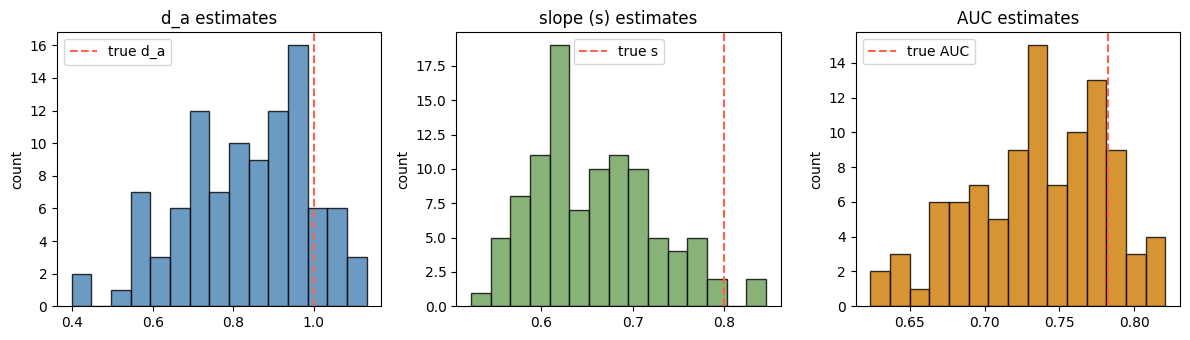

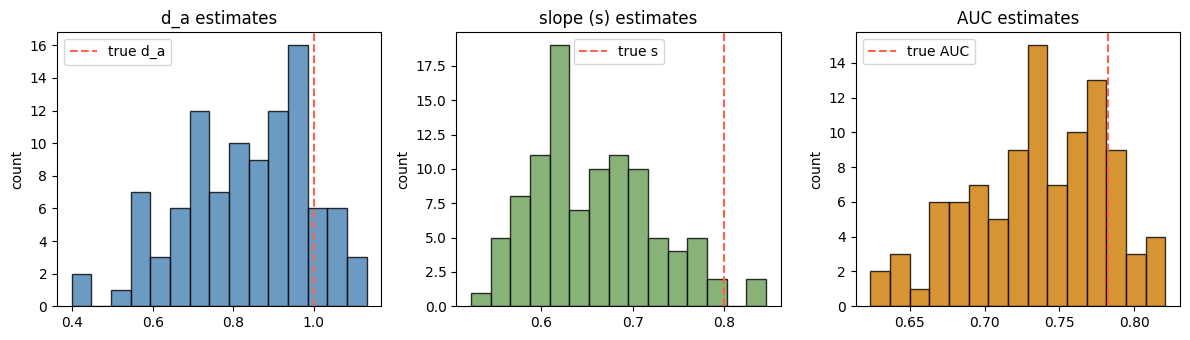

In [174]:
plot_distributions(d_a_vals, s_vals, auc_vals)

# Psychometric Function


#### General Variables

In [175]:
INTENSITIES = np.array([5, 10, 15, 20, 25, 30], dtype=float)
CORRECT_COUNTS = np.array([12, 11, 19, 27, 30, 30], dtype=float)
N_TRIALS = 30
P_GUESS = 1.0 / 3.0  # 3-alternative guessing rate

#### Helper Functions

In [176]:
def psi_315(x, alpha, beta):
    return norm.cdf((x - alpha) * beta)

In [177]:
def psi_317(x, alpha, beta, p_guess=P_GUESS):
    core = norm.cdf((x - alpha) * beta)
    return (1 - p_guess) * core + p_guess

In [178]:
def psi_319(x, alpha, beta, lapse, p_guess=P_GUESS):
    core = norm.cdf((x - alpha) * beta)
    return (1 - p_guess - lapse) * core + p_guess

In [179]:
def nll(params, model, x, k, n, p_guess=P_GUESS):
    """Negative log likelihood for binomial counts."""
    # Unpack params depending on model
    if model == "315":
        alpha, beta = params
        lapse = 0.0
        if beta <= 0:
            return np.inf
        p = psi_315(x, alpha, beta)
    elif model == "317":
        alpha, beta = params
        lapse = 0.0
        if beta <= 0:
            return np.inf
        p = psi_317(x, alpha, beta, p_guess=p_guess)
    else:  # "319"
        alpha, beta, lapse = params
        if beta <= 0 or lapse < 0 or lapse > 0.5:
            return np.inf
        p = psi_319(x, alpha, beta, lapse, p_guess=p_guess)

    p = np.clip(p, 1e-6, 1 - 1e-6)
    log_lik = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(log_lik)

In [180]:
def fit_model(model, x, k, n, initial):
    res = optimize.minimize(
        nll,
        x0=np.array(initial, dtype=float),
        args=(model, x, k, n),
        method="Nelder-Mead",
        options={"maxiter": 5000, "disp": False},
    )
    return res

In [181]:
def aic(nll_val, n_params):
    return 2 * n_params + 2 * nll_val

In [182]:
def summarize_fit(model, x, k, n):
    if model == "315":
        init = [np.median(x), 0.2]
        n_params = 2
    elif model == "317":
        init = [np.median(x), 0.2]
        n_params = 2  # p_guess is fixed at 1/3
    else:  # "319"
        init = [np.median(x), 0.2, 0.02]
        n_params = 3
    res = fit_model(model, x, k, n, init)
    params = res.x
    nll_val = nll(params, model, x, k, n)
    return {
        "model": model,
        "params": params,
        "nll": nll_val,
        "aic": aic(nll_val, n_params),
        "success": res.success,
    }

In [183]:

def evaluate_fits(fits, x_dense):
    curves = {}
    for f in fits:
        m = f["model"]
        if m == "315":
            alpha, beta = f["params"]
            curves[m] = psi_315(x_dense, alpha, beta)
        elif m == "317":
            alpha, beta = f["params"]
            curves[m] = psi_317(x_dense, alpha, beta, p_guess=P_GUESS)
        else:
            alpha, beta, lapse = f["params"]
            curves[m] = psi_319(x_dense, alpha, beta, lapse, p_guess=P_GUESS)
    return curves


Models we fit (matching Eqs. 3.15, 3.17, 3.19):
- 3.15: plain cumulative normal ?((I-?)?) ? no guess, no lapse.
- 3.17: cumulative normal with fixed P_guess=1/3 ? captures chance performance in 3AFC.
- 3.19: cumulative normal with fixed P_guess=1/3 and free lapse ? allows asymptote below 1 due to lapses.
Why: this lets us see how adding guess and lapse parameters changes fit quality and parameter estimates on the same data.

Psychometric theory and likelihood:
- Data: at each intensity I_s we observe k correct out of n=30 trials (3AFC). The binomial likelihood uses p(I_s) from the model.
- Parameters: ? is the threshold c_I shifting the curve; ? is 1/?_I controlling slope. P_guess fixed at 1/3 (chance for 3AFC). Model 3.19 adds lapse ? allowing the upper asymptote to fall below 1.
- Models:
  * 3.15: p = ?((I-?)?) (no guess, no lapse).
  * 3.17: p = (1-P_guess)?((I-?)?) + P_guess (accounts for chance performance).
  * 3.19: p = (1-P_guess-?)?((I-?)?) + P_guess (accounts for chance + lapses).
- Fitting: minimize negative log-likelihood (sum over intensities of k log p + (n-k) log(1-p)), with constraints ?>0, ??[0,0.5].
- Model selection: AIC = 2k + 2?NLL, with k=2 params for 3.15/3.17 (?,?) and k=3 for 3.19 (?,?,?). Lower AIC balances fit vs. extra parameters.

In [184]:
def run_analysis(correct_counts, label):
    print(f"=== {label} ===")
    fits = [
        summarize_fit("315", INTENSITIES, correct_counts, N_TRIALS),
        summarize_fit("317", INTENSITIES, correct_counts, N_TRIALS),
        summarize_fit("319", INTENSITIES, correct_counts, N_TRIALS),
    ]
    fits_sorted = sorted(fits, key=lambda d: d["aic"])
    for f in fits_sorted:
        p = f["params"]
        if f["model"] == "319":
            alpha, beta, lapse = p
            extra = f", lapse={lapse:.3f}"
        else:
            alpha, beta = p
            extra = ""
        print(
            f"Model {f['model']}: nll={f['nll']:.3f}, AIC={f['aic']:.3f}, "
            f"alpha={alpha:.3f}, beta={beta:.3f}{extra}, success={f['success']}"
        )
    best = fits_sorted[0]
    print(f"Lowest AIC: model {best['model']}")

    # Plot
    x_dense = np.linspace(INTENSITIES.min() - 2, INTENSITIES.max() + 2, 300)
    curves = evaluate_fits(fits_sorted, x_dense)
    plt.figure(figsize=(7, 4))
    for name, y in curves.items():
        plt.plot(x_dense, y, label=f"model {name}")
    plt.scatter(INTENSITIES, correct_counts / N_TRIALS, color="black", zorder=5, label="data")
    plt.xlabel("Intensity (dB)")
    plt.ylabel("Proportion correct")
    plt.title(label)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Experiment

=== Original data (3AFC) ===
Model 317: nll=69.854, AIC=143.708, alpha=15.692, beta=0.265, success=True
Model 319: nll=69.854, AIC=145.708, alpha=15.692, beta=0.265, lapse=0.000, success=True
Model 315: nll=73.532, AIC=151.064, alpha=10.132, beta=0.122, success=True
Lowest AIC: model 317


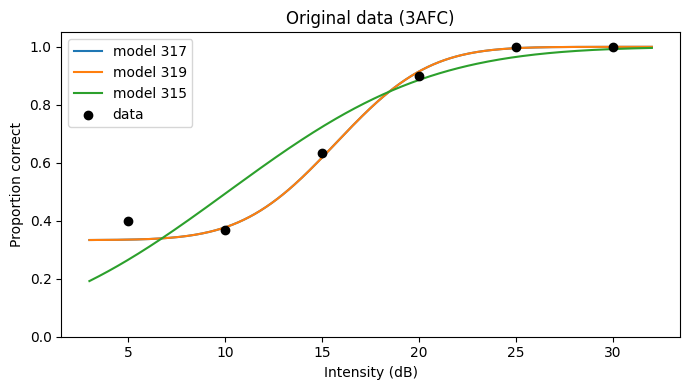

=== With lapse at 30 dB (29/30) ===
Model 319: nll=74.869, AIC=155.738, alpha=15.496, beta=0.274, lapse=0.018, success=True
Model 317: nll=76.824, AIC=157.648, alpha=15.481, beta=0.173, success=True
Model 315: nll=78.030, AIC=160.060, alpha=10.087, beta=0.109, success=True
Lowest AIC: model 319


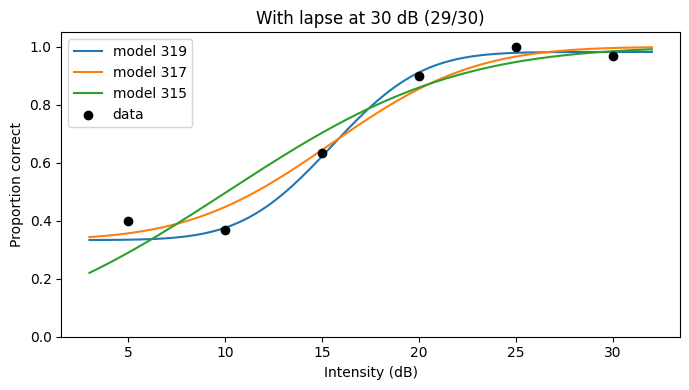

In [185]:
run_analysis(CORRECT_COUNTS, "Original data (3AFC)")
# Lapse at highest intensity: one miss at 30 dB (29/30 correct)
lapse_counts = CORRECT_COUNTS.copy()
lapse_counts[-1] = 29
run_analysis(lapse_counts, "With lapse at 30 dB (29/30)")

# Magnitude Estimation


#### General Variables

In [186]:
STEVENS_CASES = {
    "brightness_like (a=0.33)": 0.33,  # exponent < 1
    "electric_shock_like (a=3.3)": 3.3,  # exponent > 1
}

#### Helper Functions

What the helper functions do:
- `simulate_stevens`: computes I_p under Stevens? power law for a given exponent a.
- `fit_fechner`: linear least squares of I_p vs. log(I_s) to get Fechner slope m and intercept b.
- `run_case`: simulates one exponent, fits Fechner, plots simulated points and the Fechner line, and reports m,b.
Why: comparing the fitted Fechner line to the true Stevens curve shows when a log law can approximate (a<1 compressive) or fail to capture (a>1 expansive) the psychophysical relationship.

In [187]:
def simulate_stevens(is_levels, a, k=10.0):
    """Simulate perceived intensity via Stevens' law: I_p = k * I_s^a."""
    return k * (is_levels ** a)

In [188]:
def fit_fechner(is_levels, ip_values):
    """Fit Fechner's law: I_p = m * log(I_s) + b via linear regression."""
    x = np.log(is_levels)
    A = np.column_stack([x, np.ones_like(x)])
    params, *_ = np.linalg.lstsq(A, ip_values, rcond=None)
    m, b = params
    return m, b

In [189]:


def run_case(label, exponent, is_levels):
    ip_sim = simulate_stevens(is_levels, exponent)
    m, b = fit_fechner(is_levels, ip_sim)
    ip_fit = m * np.log(is_levels) + b

    print(f"{label}: Stevens exponent a={exponent}")
    print(f"  Fechner fit: slope={m:.3f}, intercept={b:.3f}")

    plt.figure(figsize=(6, 4))
    plt.scatter(is_levels, ip_sim, color="black", label="Simulated (Stevens)")
    plt.plot(is_levels, ip_fit, color="tomato", label="Fechner fit")
    plt.xlabel("Physical intensity I_s")
    plt.ylabel("Perceived intensity I_p")
    plt.title(f"{label}: Stevens vs. Fechner fit")
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Experiment

brightness_like (a=0.33): Stevens exponent a=0.33
  Fechner fit: slope=5.005, intercept=9.311


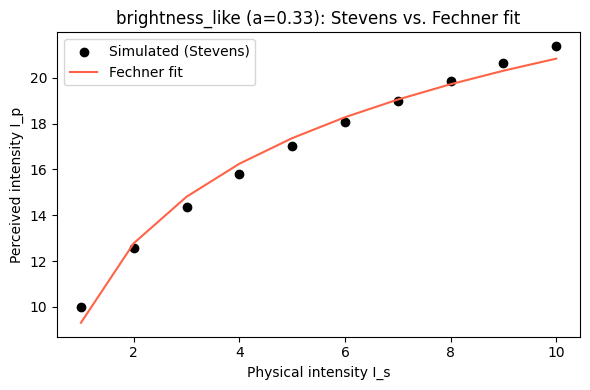

electric_shock_like (a=3.3): Stevens exponent a=3.3
  Fechner fit: slope=7127.579, intercept=-5073.165


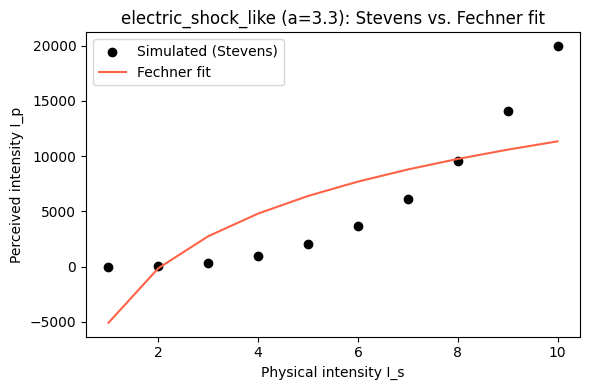

In [190]:
is_levels = np.arange(1, 11, dtype=float)

for label, a in STEVENS_CASES.items():
    run_case(label, a, is_levels)

# Psychophisics 